In [1]:
# generate graph and create adjacency
from __future__ import division
import numpy as np
import GHRGbuild
import metrics
import helperfunctions
import spectral_algorithms_new as spectral
from matplotlib import pyplot as plt
%matplotlib notebook

DendroPY not supported.


Hierarchy Level:  0 | KS Detectable:  True | Link Probabilities in / out per block:  0.002887406174363536 0.0008425337669563207
Hierarchy Level:  1 | KS Detectable:  True | Link Probabilities in / out per block:  0.006137340181987884 0.0012624391705513618
Hierarchy Level:  2 | KS Detectable:  True | Link Probabilities in / out per block:  0.01434409251711581 0.00203396401442392





 START INFERENCE
number nodes /groups
(19683, 27)


HIER SPECTRAL PARTITION -- agglomerative

Initial partition into 27 groups 

List of partitions to assess:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27] 

Current shape of network:  (19683, 19683) 

Current levels:  [27] 

Ks, local_min, below_thresh, levels
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27] [ 3  9 14 22] [ 1  3  9 27] [3 9]
agglomeration level candidate
3
Ks, local_min, below_thresh, levels
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26

/Users/mschaub/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


[[0.96374377 0.48195687 0.32152156]
 [0.48197535 0.96597353 0.64455741]
 [0.32137415 0.64457565 0.96401072]]


RESULTS

bottom level
0.9640107220401398
3 3
precision, recall
0.9645760064856148 0.9645760064856148
INFERRED PARTITION, TRUE PARTITION
[3, 9, 27]
[3, 9, 27]
[0 0 0 ... 1 1 1]
[0 0 0 ... 5 5 5]
[0 0 0 ... 8 8 8]


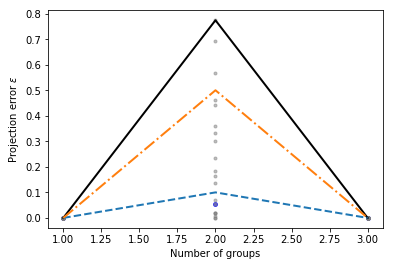

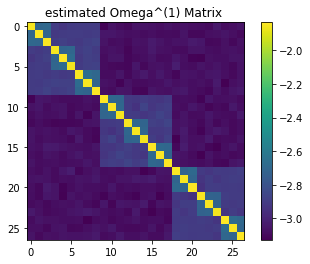

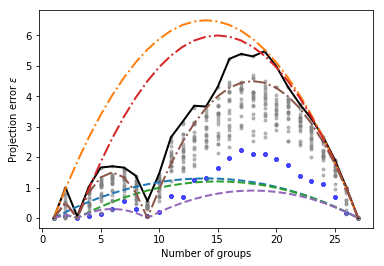

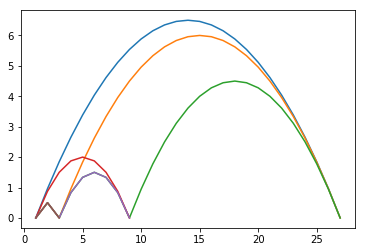

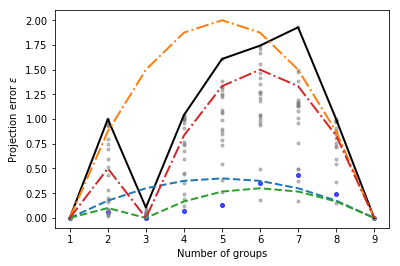

In [2]:
plt.close("all")
# Create an aggregated graph as we would have in the test loop
# and check current agglomeration practis
n = 3**9
groups_per_level = 3
n_levels = 3
snr = 6
c_bar = 30

# generate graph and create adjacency
D_actual = GHRGbuild.create2paramGHRG(n, snr, c_bar, n_levels, groups_per_level)
G = D_actual.generateNetworkExactProb()
Aorg = D_actual.to_scipy_sparse_matrix(G)

# get true hierarchy
true_pvec = D_actual.get_partition_all()

H = helperfunctions.create_partition_matrix_from_vector(true_pvec[-1])
Omegahat = np.log10(H.T*Aorg*H / (H.T.sum(axis=1)* H.T.sum(axis=1).T))
Omegahat[np.isinf(Omegahat)] = 0
plt.figure()
plt.imshow(Omegahat.A)
plt.colorbar()
plt.title("estimated Omega^(1) Matrix ")
plt.savefig("estimatedOmega.pdf")

print "\n\n\n\n\n START INFERENCE"
pvec_inf = spectral.hier_spectral_partition(Aorg, model='SBM',reps=20,noise=2e-2, Ks=None)

score_matrix = metrics.calculate_level_comparison_matrix(pvec_inf, true_pvec)
print score_matrix

precision, recall = metrics.calculate_precision_recall(score_matrix)
bottom_lvl = score_matrix[-1, -1]
print "\n\nRESULTS\n\nbottom level"
print bottom_lvl
print len(pvec_inf), len(true_pvec)
print "precision, recall"
print precision, recall

print "INFERRED PARTITION, TRUE PARTITION"
print[len(np.unique(pv)) for pv in pvec_inf]
print[len(np.unique(pv)) for pv in true_pvec]
for p in pvec_inf:
    print p
    
plt.figure(27)
plt.savefig("model_selection27.pdf")
plt.show()

30 0.0008425337669563207
18.94427190999916 0.006137340181987885 0.001262439170551362
13.422362978007502 0.01434409251711581 0.002033964014423921


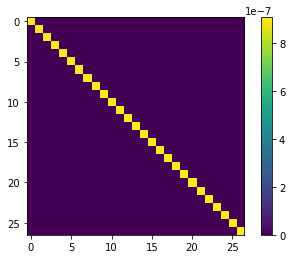

In [3]:
Eagg, Nagg = helperfunctions.compute_number_links_between_groups(Aorg, true_pvec[-1])
Omegahat = Eagg / Nagg
Omegahat = D_actual.construct_full_block_params()
ng = groups_per_level
cbar = c_bar
b0 = cbar - np.sqrt(cbar*snr)
print cbar, b0/n

cbar = cbar - (1-1/ng)*b0
a1 = cbar + (ng-1)* np.sqrt(cbar*snr)
b1 = cbar - np.sqrt(cbar*snr)
print cbar, a1*ng/n, b1*ng/n

cbar = cbar - (1-1/ng)*b1
b2 = cbar - np.sqrt(cbar*snr)                       
a2 = cbar +(ng-1)*np.sqrt(cbar*snr)
print cbar, a2*ng**2/n, b2*ng**2/n


second_level = (a1-b1)*ng/n *np.eye(9) + (b1*ng/n - b0/n) *np.ones((groups_per_level**(n_levels-1),groups_per_level**(n_levels-1)))
# plt.figure()
# plt.imshow(second_level)
# plt.colorbar()
third_level = (a2-b2)*ng**2/n *np.eye(3) + (b2*ng**2/n -b1*ng/n)*np.ones((groups_per_level**(n_levels-2),groups_per_level**(n_levels-2)))
# plt.figure()
# plt.imshow(third_level)
# plt.colorbar()

Omega_construct = b0/n * np.ones((groups_per_level**n_levels,groups_per_level**n_levels))
Omega_construct += np.kron(np.eye(3),second_level)
Omega_construct += np.kron(np.eye(9),third_level) - np.eye(27)*a1*ng/n  + np.eye(27)*(b0/n + b1/n)


plt.figure()
plt.imshow(Omega_construct - Omegahat)
plt.colorbar()

0.0013717421124828531